# Imports

In [2]:
import wandb
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import numpy as np

# Guide

See here for guide https://docs.wandb.ai/guides/track/public-api-guide

# Multiple Runs

In [3]:
api = wandb.Api() 
runs = api.runs("philipwastaken/02456_project")

### Get runs with proper hyperparameters

In [4]:
good_runs = []
for i, run in enumerate(runs): 
    
    conf = run.config['update']
    if  conf['learning_rate']==0.0003 and conf['replay_memory_capacity']==50000 and conf['batch_size']==32 and conf['num_episodes']==20000:
        status = str(run)[44:-2]
        if status == 'finished':
            good_runs.append(i)

### Split runs into each model/wrapper

In [11]:
models_id = {
    'gray' : [],
    'crop' : [],
    'scale120' : [],
    'scale84' : [],
    'scale72' : [],
    'scale60' : [],
    'scale48' : [],
    'scale36' : []
}
time_id = {}

for i, run in enumerate(runs): 
    if i in good_runs:
        summ = run.summary
        model = summ['model_path'][40:-38]
        models_id[model].append(i)
        time_id[i]=summ['_runtime']

#for key in models_id.keys():
#    models_id[key] = len(models_id[key])
models_id

{'gray': [36, 39, 42, 51, 53, 63, 82],
 'crop': [46, 52, 57, 66, 67, 81],
 'scale120': [35, 47, 54, 58, 68, 80],
 'scale84': [38, 49, 55, 59, 60, 69, 77],
 'scale72': [40, 50, 56, 61, 62, 70],
 'scale60': [9, 10, 11, 29, 45, 48],
 'scale48': [7, 8, 13, 18, 27, 41, 43, 44],
 'scale36': [12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 28, 34]}

### Model training time

In [26]:
model_time = {}
time_stats = {}

for model in models_id.keys():
    model_time[model] = []
    time_stats[model] = []
    for id in models_id[model]:
        model_time[model].append(time_id[id])
    time_stats[model].append(np.array(model_time[model]).mean()
    time_stats[model].append(np.array(model_time[model]).std()
time_stats

{'gray': 2092.330060036116,
 'crop': 2018.8487818049964,
 'scale120': 3003.113141250616,
 'scale84': 4469.593610141956,
 'scale72': 4199.691357146438,
 'scale60': 3187.2282447377397,
 'scale48': 4264.795678767813,
 'scale36': 3681.6802605769544}

## Collect reward/performance data

In [8]:
train = {}
validate = {}

for i, run in enumerate(runs):
    
    if i not in good_runs:
        continue
        
    history = run.scan_history()
    
    train[i] = []
    validate[i] = []
    for row in history:
        try:
            if 'validate/sims_per_val' in row:
                validate[i].append(row['validate/avg_reward'])
            else:
                train[i].append(row['mean_train_reward'])
        except:
            print(row)

## Visualize multiple TRAIN runs of SAME wrapper

[36, 39, 42, 51, 53, 63, 82]


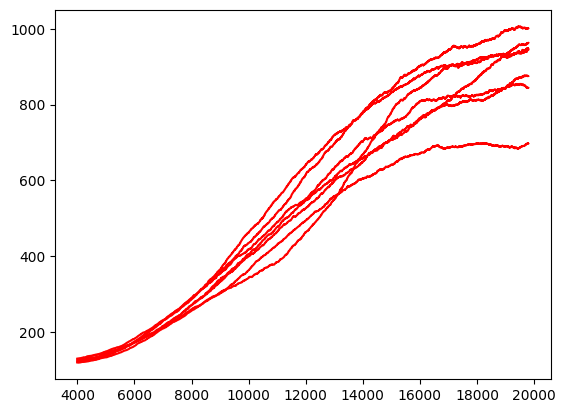

In [12]:
ids = models_id['gray']
print(ids)
for id in ids:
    plt.plot(pd.Series(train[id][:20000]).rolling(4000).mean(),c='r')
plt.show()
#plt.savefig('gray_train.pgf')

## Visualize multiple VALIDATION runs of SAME wrapper

[36, 39, 42, 51, 53, 63, 82]


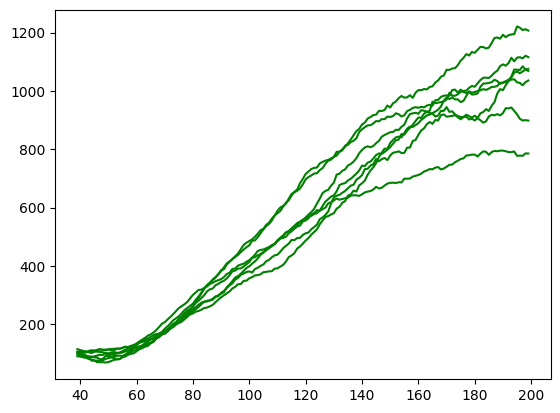

In [13]:
ids = models_id['gray']
print(ids)
for id in ids:
    plt.plot(pd.Series(validate[id][:200]).rolling(40).mean(), c='g')
plt.show()
#plt.savefig('gray_val.pgf')

## Visualize mean TRAIN run of wrappers

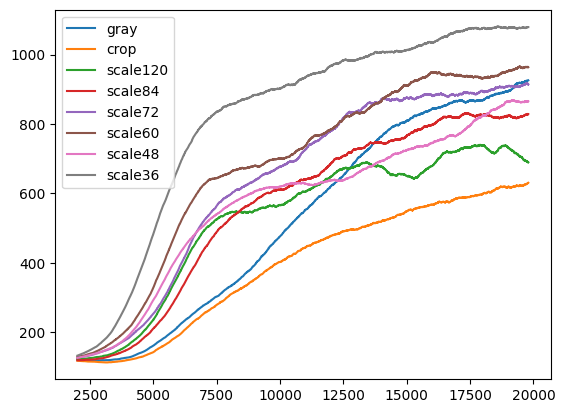

In [14]:
for model in models_id:
    arr = []
    for id in models_id[model]:
        arr.append(train[id][:19800])
    mean = np.array(arr).mean(axis=0)
    MA = pd.Series(mean).rolling(2000).mean()
    plt.plot(MA)

plt.legend(models_id.keys())
plt.savefig('all_train.png')
plt.show()

## Visualize mean VALIDATION run of wrappers

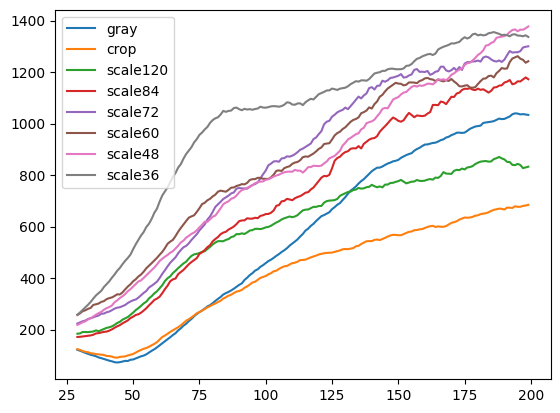

In [15]:
for model in models_id:
    arr = []
    for id in models_id[model]:
        arr.append(validate[id][:200])
    mean = np.array(arr).mean(axis=0)
    MA = pd.Series(mean).rolling(30).mean()
    plt.plot(MA)

plt.legend(models_id.keys())
plt.savefig('all_val.png')
plt.show()